In [1]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn

Instructions for updating:
Use the retry module or similar alternatives.


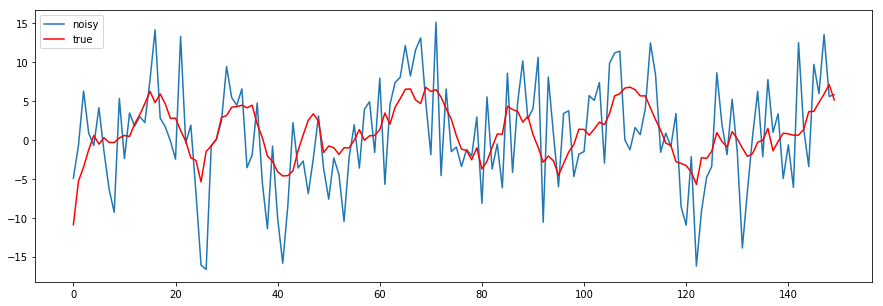

In [27]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softplus(x):
    return np.log(1 + np.exp(x)) + 1e-5

np.random.seed(1)
H = 140; T = 300; N = 1000; training_size = 900
h = np.zeros((N, T + 1, H)); 
# h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(H), size=N)
y = np.zeros((N, T + 1, 1)); y[:, 0] = np.zeros((N, 1))
sigma_c = 5.3
sigma_b = 1.5

A = 0.8 * np.random.randn(H, H)
R = scipy.linalg.expm(A - A.T)
B = 0.2 * np.random.randn(1, H)
b = 0.5 * np.random.randn(H, 1)
c = 1 * np.random.randn(H, 1)
bias_h = np.random.rand(1, H)
d = 0.01 * np.random.rand(H, 1)

for i in range(1, T + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i-1, :], R) + np.dot(y[:, i-1], B)) + 0.7 * h[:, i-1, :] + bias_h
    y[:, i] = (1 * np.dot(h[:, i, :], b) + np.tanh(np.dot(h[:, i, :], c)) - 1 
               + 3 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 2) *
#                + sigma_b * 
               np.random.randn(N, 1))

y = y[:, 1:]
y = y - np.mean(y, 1, keepdims=True)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
y_tilde = (y 
           + sigma_c
           * np.random.randn(N, T, 1))

seq_length = 150
training_data = y_tilde[:training_size]
testing_data = y_tilde[training_size:]

plt.plot(y_tilde[0, :seq_length], label='noisy');
plt.plot(y[0, :seq_length], 'r', label='true');
plt.legend();

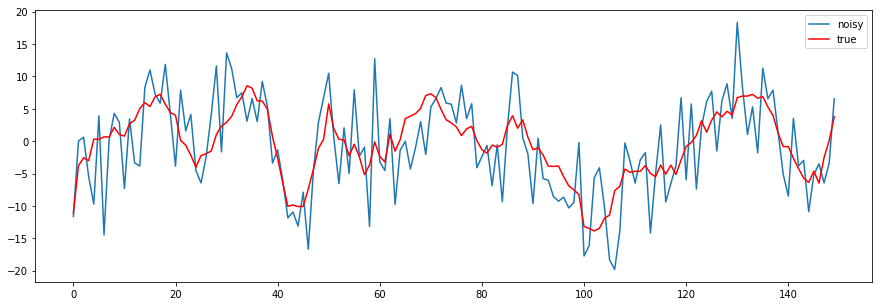

In [32]:
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[idx, :seq_length], label='noisy');
plt.plot(y[idx, :seq_length], 'r', label='true');
plt.legend();

In [5]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [6]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std=None, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        if std is not None:
            self._std = std[None, None]
        else:
            self._layer_1 = tf.layers.Dense(100, tf.nn.relu)
            self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        try: 
            std = self._layer_sigma(self._layer_1(hidden)) + 1e-5
            return (mean, std), state
        except AttributeError:
            n_samples = mean.shape[0]
            return (mean, tf.tile(self._std, (n_samples, self._event_size))), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.MultivariateNormalDiag(mean, std).sample()
        return (mean, std, sample), (state, sample)
    
class BeamSamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a Beam Search sequence in autoregressive mode by sampling and pruning
    at every step
    """
    
    def __init__(self, cell, output_size, branch_width, reuse=None):
        super(BeamSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._branch_width = branch_width
        
    @property
    def state_size(self):
        (self._cell.state_size, self._output_size, 1)
        
    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, _, state_and_sample_and_prob):
        (state, sample, probs) = state_and_sample_and_prob
        (mean, std), state = self._cell(sample, state)
        dist = tfd.MultivariateNormalDiag(mean, std)
        sample = dist.sample((self._branch_width))
        new_probs = dist.log_prob(sample)
        new_probs = tf.reshape(new_probs, [-1])
        probs = tf.reshape(tf.tile(probs[None, ..., 0], [self._branch_width, 1]), [-1])
        best_probs, best_idx = tf.nn.top_k(new_probs + probs, k=self._branch_width)
        best_samples = tf.gather(tf.reshape(sample, [-1, self._output_size]), best_idx)
        
        return (mean, best_samples), (state, best_samples, best_probs[..., None])

In [33]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        
        self.initialise_variables
        self.q_y = self.make_posterior
        self.p_y = self.make_prior
        self.compute_elbo
        self.optimise
    
    @define_scope
    def initialise_variables(self):
        self._post_cell_f = tf.nn.rnn_cell.BasicRNNCell(self._H)
        self._post_cell_b = tf.nn.rnn_cell.BasicRNNCell(self._H)
        self._gen_std = tf.nn.softplus(tf.get_variable('gen_std', shape=(), initializer=tf.constant_initializer(1)))
        self._optimiser = tf.train.AdamOptimizer(0.001)
    
    @define_scope
    def make_posterior(self):        
        (out_f, out_b), _ = tf.nn.bidirectional_dynamic_rnn(
                                                self._post_cell_f, self._post_cell_b, 
                                                inputs=self._data, dtype=tf.float32
        )
        
        hidden = tf.concat([out_f, out_b], 2)
        means = tf.layers.dense(hidden, self._D)
        stds = tf.layers.dense(hidden, self._D, tf.nn.softplus)
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_prior(self):
        means = tf.get_variable('prior_means', shape=(self._T), initializer=tf.constant_initializer(0.))
        stds = tf.nn.softplus(tf.get_variable('prior_stds', shape=(self._T), initializer=tf.constant_initializer(1.)))
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_kl(self):
        return tf.reduce_sum(tfd.kl_divergence(self.q_y, self.p_y))
    
    @define_scope
    def make_reconstruction(self):
        self._code_y = self.q_y.sample(self._Sz)
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, scale_identity_multiplier=self._gen_std)
        data = tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1))
        return tf.reduce_sum(gen_prob.log_prob(data))/self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl = self.make_kl        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl
        
        return loss, kl, reconstruction

    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [ ]:
tf.reset_default_graph()

n_samples = 500; batch_size = 50;

x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=30, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])

sess.run(tf.global_variables_initializer())
elbos = []; kls_z = []; llks = []; test_elbos = []

for i in range(50001):
    idx = np.random.randint(0, training_size, batch_size)
    batch = training_data[idx, :seq_length]

    elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)

    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL (y):', kl_z, 'Reconstruction:', llk)

    sess.run(gen_model.optimise, {x_: batch})

Iteration: 0 ELBO: -1005969.44 KL (y): 878036.8 Reconstruction: -127932.64
Iteration: 1000 ELBO: 527476.3 KL (y): -580483.94 Reconstruction: -53007.63


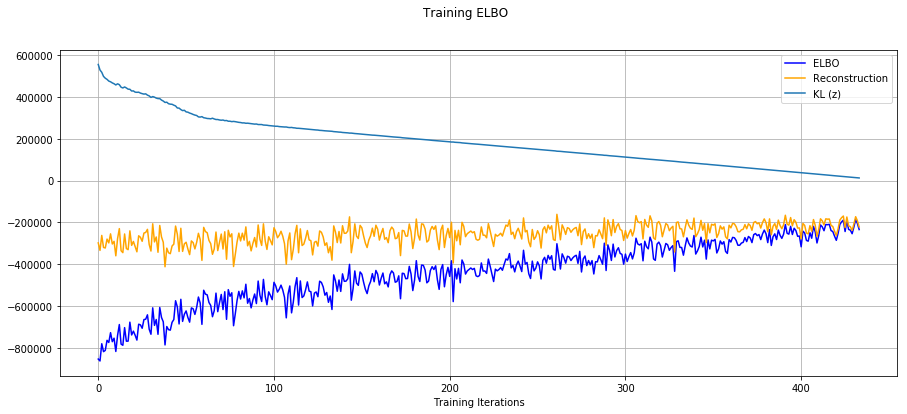

In [13]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (z)')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

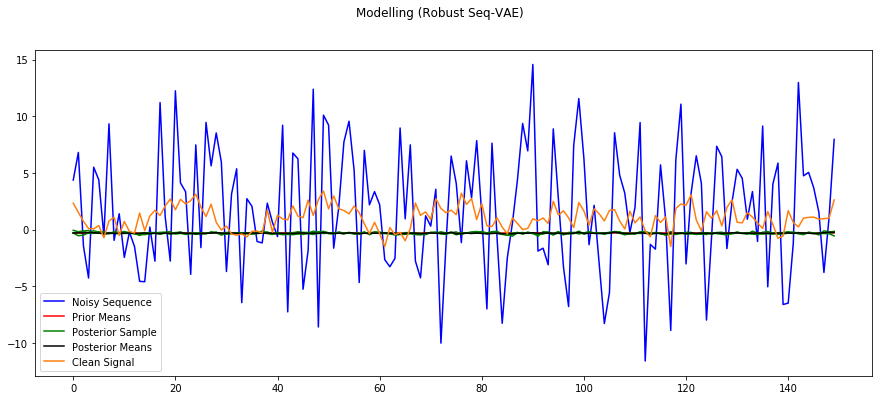

In [26]:
np.random.seed(0)
idx = np.random.randint(0, testing_data.shape[0], batch_size)
batch = testing_data[idx, ...]

prior_means = sess.run(gen_model.p_y.mean(), {x_: batch})
post_means = sess.run(gen_model.q_y.mean(), {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})

np.random.seed(0)
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(prior_means[..., None], 'r-', label='Prior Means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot(post_means[i], 'k', label='Posterior Means')
plt.plot([], [])
plt.plot(y[training_size + idx[i], 50:50+seq_length], label='Clean Signal')
plt.suptitle('Modelling (Robust Seq-VAE)')
plt.legend();
# plt.savefig('robust-seq-vae-modelling.pdf', bbox_inches='tight')

In [100]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size):
        self._data = data                                         # B x T x D
        self._B = batch_size                                      # B
        self._T = seq_length                                      # T
        self._D = 1                                               # D
        self._H = n_hidden                                        # H
        self._Sz = n_samples                                      # Sz
        
        self.initialise_variables
        self.q_y = self.make_posterior
        self.p_y = self.make_transitional
        self.compute_elbo
        self.optimise
    
    @define_scope
    def initialise_variables(self):
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D)
        self._post_cell_f = tf.nn.rnn_cell.BasicRNNCell(self._H)
        self._post_cell_b = tf.nn.rnn_cell.BasicRNNCell(self._H)
        self._post_std = tf.nn.softplus(tf.get_variable('post_std', shape=(), initializer=tf.constant_initializer(1)))
        self._gen_std = tf.nn.softplus(tf.get_variable('gen_std', shape=(), initializer=tf.constant_initializer(1)))
        self._optimiser = tf.train.AdamOptimizer(0.001)
    
    @define_scope
    def make_posterior(self):        
        (out_f, out_b), _ = tf.nn.bidirectional_dynamic_rnn(
                                                self._post_cell_f, self._post_cell_b, 
                                                inputs=self._data, dtype=tf.float32
        )
        
        hidden = tf.concat([out_f, out_b], 2)
        means = tf.layers.dense(hidden, self._D)
        means = tf.identity(means, name='post_means')
        return tfd.MultivariateNormalDiag(means, scale_identity_multiplier=self._post_std)
    
    @define_scope
    def make_transitional(self):
        self._code_y = self.q_y.sample((self._Sz))
        inputs = tf.reshape(self._code_y, [-1, self._T, self._D])
        (means, stds), _ = dynrnn(self._gauss_cell, inputs=inputs, dtype=tf.float32)
        means = tf.identity(tf.reshape(means, [self._Sz, self._B, self._T, self._D]), name='means')
        stds = tf.identity(tf.reshape(stds, [self._Sz, self._B, self._T, self._D]), name='stds')
        return tfd.MultivariateNormalDiag(means, stds)
    
    @define_scope
    def make_kl(self):
        return tf.reduce_sum(tfd.kl_divergence(self.q_y, self.p_y))/self._Sz
    
    @define_scope
    def make_reconstruction(self):
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, scale_identity_multiplier=self._gen_std)
        data = tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1))
        return tf.reduce_sum(gen_prob.log_prob(data))/self._Sz
    
    @define_scope
    def compute_elbo(self):
        kl = self.make_kl        
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl
        
        return loss, kl, reconstruction

    @define_scope
    def optimise(self):
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0]))
#         gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [101]:
tf.reset_default_graph()

n_samples = 500; batch_size = 50;

x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=50, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])

sess.run(tf.global_variables_initializer())
elbos = []; kls_z = []; llks = []; test_elbos = []

for i in range(50001):
    idx = np.random.randint(0, training_size, batch_size)
    batch = training_data[idx, :seq_length]

    elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
    elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)

    if i % 1000 == 0:
        print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk)

    sess.run(gen_model.optimise, {x_: batch})

Iteration: 0 ELBO: -373731.9 KL (z): 18585.447 Reconstruction: -355146.47


KeyboardInterrupt: 

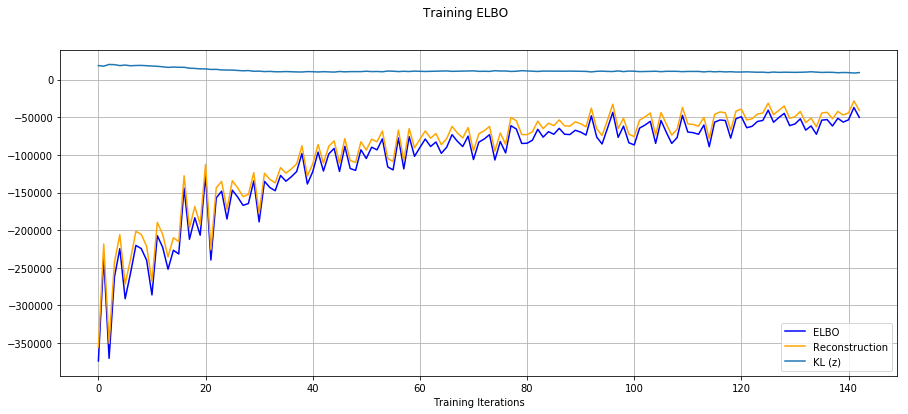

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (z)')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

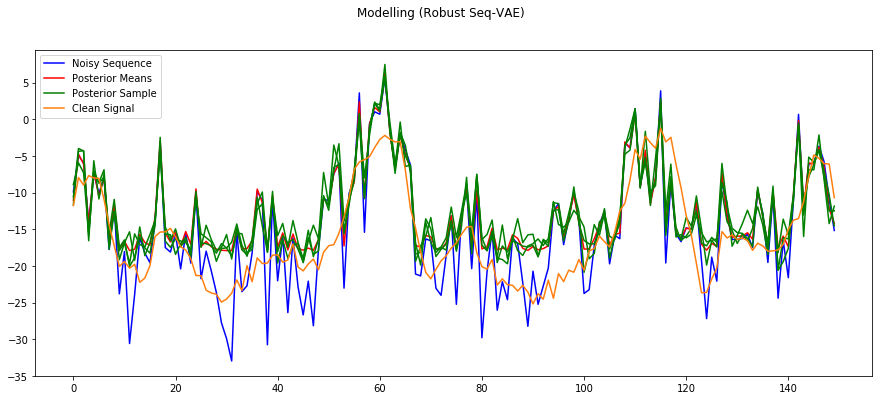

In [105]:
np.random.seed(0)
testing_data = y_tilde[training_size:, :seq_length]
idx = np.random.randint(0, y_tilde.shape[0] - training_size, batch_size)
batch = testing_data[idx, ...]

trans_means_op = tf.get_default_graph().get_tensor_by_name('make_posterior/post_means:0')
means = sess.run(trans_means_op, {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})

np.random.seed(6)
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(means[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot([], [])
plt.plot(y[training_size + idx[i], :seq_length], label='Clean Signal')
plt.suptitle('Modelling (Robust Seq-VAE)')
plt.legend();